In [1]:
cd ..

C:\Users\johan\github\designresolver


In [2]:
from graphutils import draw_graph_graphical_props, flat_graph_formulation, Node, VAR, COMP, SOLVER
from nestedgraph import build_typedgraph
from compute import Var, Par
from unitutils import get_unit, ureg
from execution import sympy_fx_inputs, Component, edges_from_components
from collections import OrderedDict
from itertools import chain

In [3]:
x,c,d,z = Var('x'), Var('c'), Var('d'), Var('z')

In [4]:
class SolverRef():
    def __init__(self, idx, modelref):
        self.model = modelref
        self.idx = idx
class Model():
    def __init__(self):
        self.components = []
        self.Ftree = OrderedDict()
        self.Stree = dict()
        self.Vtree = dict()
        self.root = SolverRef(1,self)
        self.comp_by_var = dict()

In [5]:
def var_from_expr(name, expr, unit=None, forceunit=False):
    newvar = Var(name, unit=unit)
    newvar.forceunit=forceunit # TODO: HACK for sympy function
    if not forceunit:
        fx, inputs, inpunitsflat = sympy_fx_inputs(expr)
        rhs_unit = get_unit(fx, inpunitsflat)[0] #get_unit returns a vector output depending on fx
        if unit != None:
            assert ureg(unit).dimensionality == rhs_unit.dimensionality
    if unit == None:
        newvar.varunit = ureg.Quantity(1, rhs_unit.to_base_units().units)
    return newvar

In [25]:
def adda(solver, left, right, *args, **kwargs):
    model = solver.model
    comp_idx = len(model.Ftree)
    if isinstance(left, str):
        left = var_from_expr(left, right, *args, **kwargs)
    comp = Component.fromsympy(right, left, component=comp_idx)
    model.components.append(comp)
    model.Ftree[comp_idx] = solver.idx
    model.comp_by_var[left]=comp_idx
    return left

In [26]:
def addf(solver, right):
    model = solver.model
    comp_idx = len(model.Ftree)
    comp = Component.fromsympy(right, component=comp_idx)
    model.components.append(comp)
    model.Ftree[comp_idx] = solver.idx
    return comp_idx

In [27]:
def addsolver(solver, comps=None, solvefor=None):
    comps = comps if comps else []
    solvefor = solvefor if solvefor else []
    model = solver.model
    next_solver_idx = max(chain(model.Stree.values(),[1]))+1
    model.Stree[next_solver_idx] = solver.idx
    for elt in comps:
        model.Ftree[elt] = next_solver_idx
    for elt in solvefor:
        model.Vtree[elt] = next_solver_idx
    return SolverRef(next_solver_idx, model)
def setsolvefor(solver, solvefor):
    model = solver.model
    for elt in solvefor:
        model.Vtree[elt.varid] = solver.idx

In [28]:
model = Model()
m = model.root
y = adda(m, 'y', x)
a = adda(m, 'a', c+y)
b = adda(m, 'b', a)
addf(m, b+d)
solver = addsolver(m) 
addf(solver, a+d)
setsolvefor(solver, [d]) 
e = adda(m, 'e', c+b)

In [29]:
model.comp_by_var[a]

1

In [10]:
edges = edges_from_components(model.components)
tree = model.Ftree, model.Stree, model.Vtree

In [11]:
edges, tree

(({0: ('x',),
   1: ('y', 'c'),
   2: ('a',),
   3: ('b', 'd'),
   4: ('a', 'd'),
   5: ('b', 'c')},
  {0: ('y',), 1: ('a',), 2: ('b',), 3: (None,), 4: (None,), 5: ('e',)},
  {}),
 (OrderedDict([(0, 1), (1, 1), (2, 1), (3, 1), (4, 2), (5, 1)]),
  {2: 1},
  {'d': 2}))

In [12]:
nodetyperepr = {VAR: '{}', COMP: 'f_{}', SOLVER: 's_{}'}

In [13]:
graphs = build_typedgraph(edges, tree, nodetyperepr)

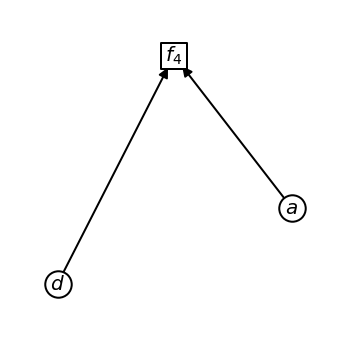

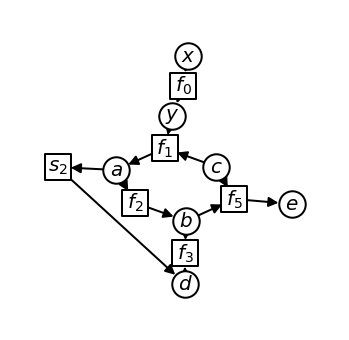

In [22]:
for key,graph in graphs.items():
    draw_graph_graphical_props(graph, {}, prog='neato', figsize=(6,6))

In [16]:
G = flat_graph_formulation(*edges, nodetyperepr=nodetyperepr)

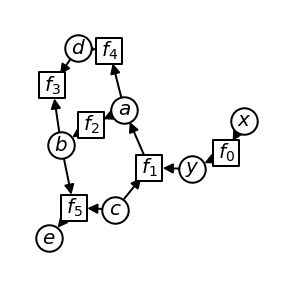

In [17]:
draw_graph_graphical_props(G, {}, prog='sfdp', figsize=(5,5))

In [24]:
from operators import sort_scc, reorder_merge_solve

In [20]:
merge_order = sort_scc(G)

In [21]:
merge_order

[{f_0}, {f_1}, {f_2}, {f_4}, {f_3}, {f_5}]

In [22]:
tree

(OrderedDict([(0, 1), (1, 1), (2, 1), (3, 1), (4, 2), (5, 1)]), {2: 1}, {d: 2})

In [25]:
nedges_opt, ntree_opt = reorder_merge_solve(edges, tree, merge_order, 1, True)

In [27]:
ntree_opt

(OrderedDict([(0, 1), (1, 1), (2, 1), (4, 2), (3, 1), (5, 1)]), {2: 1}, {d: 2})